# Wine Quality Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (4898, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Head:
    fixed acidity  vo

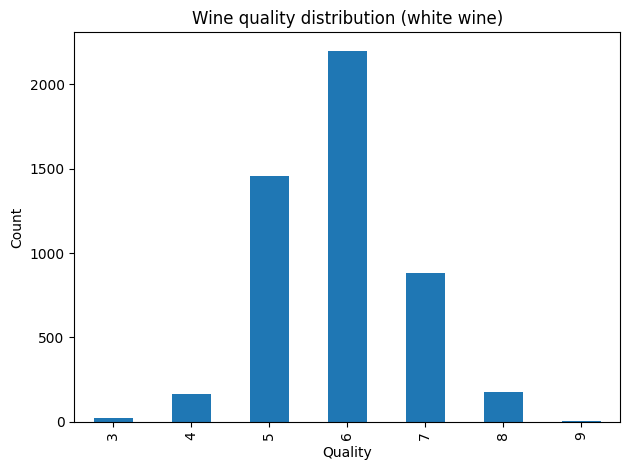

In [8]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabicl import TabICLClassifier

path = "./data/winequality-white.csv"
df = pd.read_csv(path, sep=";")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = "quality"
quality_counts = df[target_col].value_counts().sort_index()
print("\nQuality value counts:\n", quality_counts)

feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

plt.figure()
quality_counts.plot(kind="bar")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Wine quality distribution (white wine)")
plt.tight_layout()
plt.show()

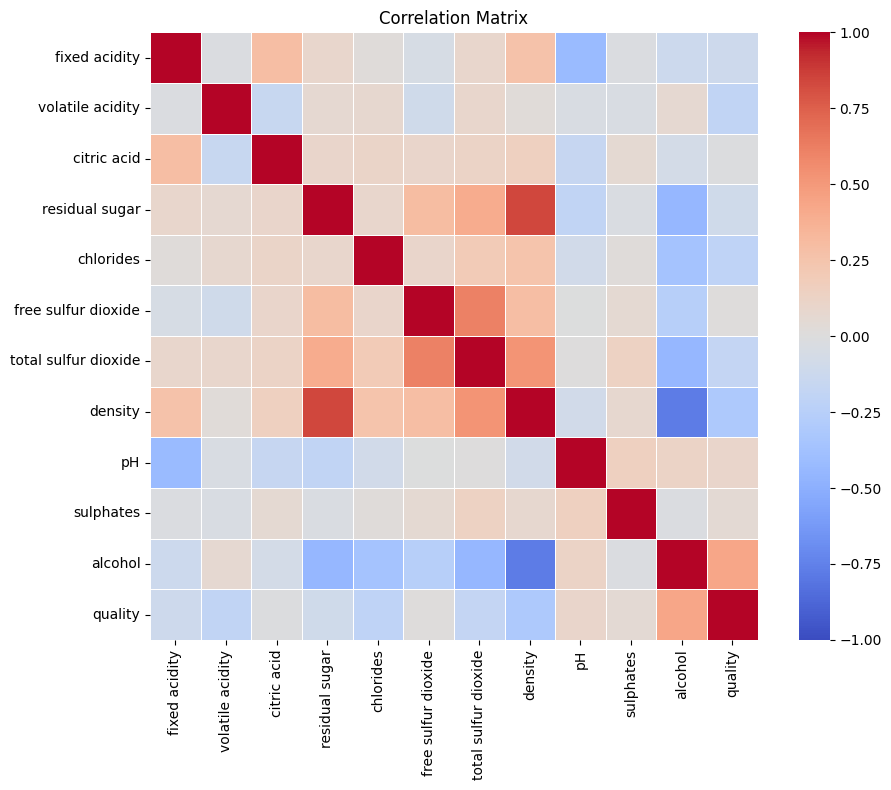

In [9]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [10]:
def timed_fit_predict(model, X_tr, y_tr, X_te):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    y_hat = model.predict(X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    return y_hat, fit_s, pred_s

### TabPFN

In [11]:
fold_summaries = []
all_y_true, all_y_pred = [], []

kf = KFold(n_splits=5, shuffle=True, random_state=21)

rmses, maes, r2s = [], [], []
fit_times, pred_times = [], []

warm_model = TabPFNRegressor(device="cuda")
_ = warm_model.fit(X.iloc[:256], y.iloc[:256])
_ = warm_model.predict(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    model = TabPFNRegressor(device="cuda")
    y_hat, fit_s, pred_s = timed_fit_predict(model, X_tr, y_tr, X_te)

    rmse = root_mean_squared_error(y_te, y_hat)
    mae = mean_absolute_error(y_te, y_hat)
    r2 = r2_score(y_te, y_hat)

    rmses.append(rmse); maes.append(mae); r2s.append(r2)
    fit_times.append(fit_s); pred_times.append(pred_s)

    fold_summaries.append(
        {"fold": fold, "rmse": rmse, "mae": mae, "r2": r2, "fit_s": fit_s, "pred_s": pred_s}
    )
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(np.asarray(y_hat))

    print(f"Fold {fold}: RMSE={rmse:.4f} MAE={mae:.4f} R2={r2:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

print(
    f"\nTabPFN 5-fold CV: RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f}, "
    f"MAE = {np.mean(maes):.4f} ± {np.std(maes):.4f}, "
    f"R2 = {np.mean(r2s):.4f} ± {np.std(r2s):.4f}"
)
print(
    f"Timing: fit = {np.mean(fit_times):.2f}s ± {np.std(fit_times):.2f}, "
    f"predict = {np.mean(pred_times):.2f}s ± {np.std(pred_times):.2f}"
)

Fold 1: RMSE=0.5996 MAE=0.4383 R2=0.5172 | fit=0.301s pred=1.888s
Fold 2: RMSE=0.6080 MAE=0.4447 R2=0.5147 | fit=0.299s pred=1.888s
Fold 3: RMSE=0.6195 MAE=0.4659 R2=0.5064 | fit=0.296s pred=1.909s
Fold 4: RMSE=0.6235 MAE=0.4573 R2=0.5306 | fit=0.291s pred=1.900s
Fold 5: RMSE=0.6482 MAE=0.4607 R2=0.4796 | fit=0.299s pred=1.776s

TabPFN 5-fold CV: RMSE = 0.6198 ± 0.0165, MAE = 0.4534 ± 0.0103, R2 = 0.5097 ± 0.0169
Timing: fit = 0.30s ± 0.00, predict = 1.87s ± 0.05


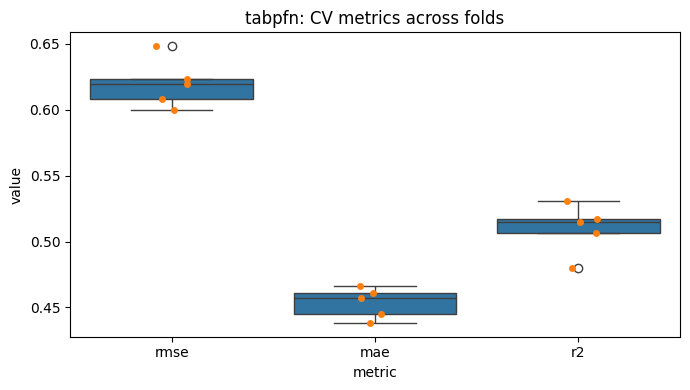

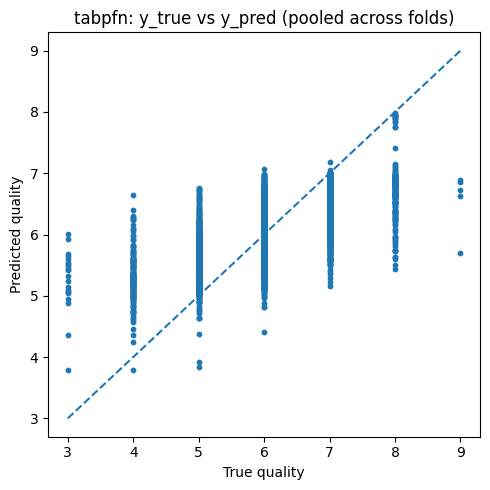

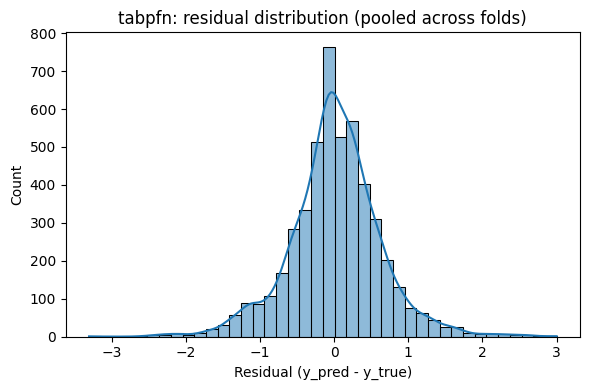

In [12]:

MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": pd.DataFrame(fold_summaries),
    "y_true_cv": np.concatenate(all_y_true).astype(float),
    "y_pred_cv": np.concatenate(all_y_pred).astype(float),
}

cv_metrics_df = MODEL_RESULTS[model_name]["cv_metrics_df"]
y_true_cv = MODEL_RESULTS[model_name]["y_true_cv"]
y_pred_cv = MODEL_RESULTS[model_name]["y_pred_cv"]

cv_metrics_long_df = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["rmse", "mae", "r2"],
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=cv_metrics_long_df, x="metric", y="value")
sns.stripplot(data=cv_metrics_long_df, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_true_cv, y_pred_cv, s=10)
mn = float(min(y_true_cv.min(), y_pred_cv.min()))
mx = float(max(y_true_cv.max(), y_pred_cv.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title(f"{model_name}: y_true vs y_pred (pooled across folds)")
plt.tight_layout()
plt.show()

residuals_cv = y_pred_cv - y_true_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals_cv, bins=40, kde=True)
plt.xlabel("Residual (y_pred - y_true)")
plt.title(f"{model_name}: residual distribution (pooled across folds)")
plt.tight_layout()
plt.show()


### TabICL